<center> <h1>Assignment #3</h1> </center>
<center> <h2>DSP</h2> </center>


| Name | Section | B.N. |
|: ----------- | :--- | :--- |
| Ahmed Abdelsalam AbdelKhalek | 1 | 16 |
| Omar Magdy Mohammed Ahmed | 3 | 10 |
| Amr Adel Ahmed Okasha | 3 | 13 |

In [45]:
from skimage.io import imread, imshow
from skimage.filters import prewitt_h,prewitt_v
import os
from os import listdir
import numpy as np 
from matplotlib import pyplot as plt
import pandas as pd    
from scipy.fft import dct
from sklearn.decomposition import PCA
import numpy as np
from sklearn.metrics import accuracy_score
from scipy.stats import mode
from scipy.fft import dct
from sklearn.decomposition import PCA
import numpy as np
from sklearn.cluster import KMeans
import numpy as np
from sklearn import mixture
from sklearn import svm
from skimage.feature import hog
from skimage import data, exposure
import tensorflow as tf
import cv2
import time
from sklearn.metrics import confusion_matrix


# 1. Data Loading

In [46]:
x_tst=[]
y_tst=[]                      
#TST_PATH = r'D:\4th year\4th_2ndterm\DSP\projects\Assignment 2\Reduced MNIST Data\Reduced Testing data' ## windows
TST_PATH = r'Reduced MNIST Data/Reduced Testing data' ## linux

for digit in listdir(TST_PATH):
    #for ex in listdir(TST_PATH+'\\'+digit):
        #x_tst.append(imread(TST_PATH+'\\'+digit+'\\'+ex))
    for ex in listdir(TST_PATH+'/'+digit):
        x_tst.append(imread(TST_PATH+'/'+digit+'/'+ex))
        y_tst.append(digit)
x_tst=np.asarray(x_tst)
y_tst=np.asarray(y_tst)

x_train=[]
y_train=[]
#TRAIN_PATH = r'D:\4th year\4th_2ndterm\DSP\projects\Assignment 2\Reduced MNIST Data\Reduced Trainging data' ## windows
TRAIN_PATH = r'Reduced MNIST Data/Reduced Trainging data' ## linux
for digit in listdir(TRAIN_PATH):
    #for ex in listdir(TRAIN_PATH+'\\'+digit):
        #x_train.append(imread(TRAIN_PATH+'\\'+digit+'\\'+ex))
    for ex in listdir(TRAIN_PATH+'/'+digit):
        x_train.append(imread(TRAIN_PATH+'/'+digit+'/'+ex))
        y_train.append(digit)
x_train=np.asarray(x_train).reshape((10000,28,28))
print(x_train.shape) 
x_tst=np.asarray(x_tst).reshape((2000,28,28))
print(x_tst.shape)
y_train=np.asarray(y_train).astype(int)
y_tst=np.asarray(y_tst).astype(int)

(10000, 28, 28)
(2000, 28, 28)


# 2. Feature extraction
## 2.1 DCT Feature extraction

In [51]:
t=time.time()
dct_train_data = dct(dct(x_train, axis=1), axis=2)
print(dct_train_data.shape)

rows=28
columns=28
dct_train_data_compressed=np.empty((10000,180))
solution=[]
for k in range(10000):    
    solution=[]
    for i in range(rows):
        for j in range(columns):
            if((i+j) < 19):
                solution.append(dct_train_data[k, i, j])
    dct_train_data_compressed[k]=np.asarray(solution[:-10])
t_elapsed=time.time()-t
print(dct_train_data_compressed.shape)

dct_tst_data = dct(dct(x_tst, axis=1), axis=2)
print(dct_tst_data.shape)
dct_tst_data_compressed=np.empty((2000,180))
for k in range(2000):    
    solution=[]
    for i in range(rows):
        for j in range(columns):
            if((i+j) < 19):
                solution.append(dct_tst_data[k, i, j])
    dct_tst_data_compressed[k]=np.asarray(solution[:-10])
print(dct_tst_data_compressed.shape)

x_train_dct=dct_train_data_compressed
x_tst_dct=dct_tst_data_compressed
print(t_elapsed)


(10000, 28, 28)
(10000, 180)
(2000, 28, 28)
(2000, 180)
1.9471726417541504


## 2.2 PCA Feature extraction


In [48]:
pca_breast = PCA(n_components=270)
t=time.time()
x_train_pca = pca_breast.fit_transform(x_train.reshape((10000,784)))
t_elapsed=time.time()-t
x_tst_pca = pca_breast.transform(x_tst.reshape((2000,784)))
print(t_elapsed)
sum(pca_breast.explained_variance_ratio_)


13.313722372055054


0.9524617477699258

## 2.3 HOG Feature extraction

In [49]:
def HOG_(images):
    feature_array=[]
    for image in images:
        ret, bw_img = cv2.threshold(image,127,255,cv2.THRESH_BINARY)
        features, hog_img = hog(bw_img, orientations=8, pixels_per_cell=(6, 6), visualize=True, multichannel=False)

        feature_array.append(features)
    feature_array=np.asarray(feature_array)
    

    return feature_array
x_tst_edge=HOG_(x_tst)
t=time.time()
x_train_edge=HOG_(x_train)
t_elapsed=time.time()-t
print(t_elapsed)

25.643143892288208


# 3. Classifiers
## 3.1 K-Mean Classifier

In [6]:
def KM(X,Y,Xt,Yt,n):
    
    t = time.time()

    kmeans = KMeans(n_clusters=n, random_state=0).fit(X)
    t_elapsed=time.time()-t
    classes=kmeans.labels_
    
    labels = np.zeros_like(classes)
    translation=np.zeros((n,1))
    for i in range(n):
        mask = (classes == i)
        labels[mask] = mode(Y[mask])[0]
        translation[i]=mode(Y[mask])[0]
    
    prediction =kmeans.predict(Xt)
    for i in range(len(prediction)):
        prediction[i]=translation[prediction[i]]
     
    accuarcy=accuracy_score(prediction, Yt)
    train_accuarcy=accuracy_score(labels, Y)
    
    return train_accuarcy,accuarcy,t_elapsed

In [7]:
[acc_KM_10_pca_train,acc_KM_10_pca_tst,time_KM_10_pca_train]=KM(x_train_pca,y_train,x_tst_pca,y_tst,10) 
[acc_KM_40_pca_train,acc_KM_40_pca_tst,time_KM_40_pca_train]=KM(x_train_pca,y_train,x_tst_pca,y_tst,40)
[acc_KM_160_pca_train,acc_KM_160_pca_tst,time_KM_160_pca_train]=KM(x_train_pca,y_train,x_tst_pca,y_tst,160)

[acc_KM_10_dct_train,acc_KM_10_dct_tst,time_KM_10_dct_train]=KM(x_train_dct,y_train,x_tst_dct,y_tst,10) 
[acc_KM_40_dct_train,acc_KM_40_dct_tst,time_KM_40_dct_train]=KM(x_train_dct,y_train,x_tst_dct,y_tst,40)
[acc_KM_160_dct_train,acc_KM_160_dct_tst,time_KM_160_dct_train]=KM(x_train_dct,y_train,x_tst_dct,y_tst,160)

[acc_KM_10_edge_train,acc_KM_10_edge_tst,time_KM_10_edge_train]=KM(x_train_edge,y_train,x_tst_edge,y_tst,10) 
[acc_KM_40_edge_train,acc_KM_40_edge_tst,time_KM_40_edge_train]=KM(x_train_edge,y_train,x_tst_edge,y_tst,40) 
[acc_KM_160_edge_train,acc_KM_160_edge_tst,time_KM_160_edge_train]=KM(x_train_edge,y_train,x_tst_edge,y_tst,160) 

print('KM 10')
print('[pca_train, pca_tst,Time_elapsed]',[acc_KM_10_pca_train,acc_KM_10_pca_tst,time_KM_10_pca_train])
print('[dct_train, dct_tst,Time_elapsed]',[acc_KM_10_dct_train,acc_KM_10_dct_tst,time_KM_40_pca_train])
print('[hog_train, hog_tst,Time_elapsed]',[acc_KM_10_edge_train,acc_KM_10_edge_tst,time_KM_160_pca_train])

print('KM 40')
print('[pca_train, pca_tst,Time_elapsed]',[acc_KM_40_pca_train,acc_KM_40_pca_tst,time_KM_10_dct_train])
print('[dct_train, dct_tst,Time_elapsed]',[acc_KM_40_dct_train,acc_KM_40_dct_tst,time_KM_40_dct_train])
print('[hog_train, hog_tst,Time_elapsed]',[acc_KM_40_edge_train,acc_KM_40_edge_tst,time_KM_160_dct_train])

print('KM 160')
print('[pca_train, pca_tst,Time_elapsed]',[acc_KM_160_pca_train,acc_KM_160_pca_tst,time_KM_10_edge_train])
print('[dct_train, dct_tst,Time_elapsed]',[acc_KM_160_dct_train,acc_KM_160_dct_tst,time_KM_40_edge_train])
print('[hog_train, hog_tst,Time_elapsed]',[acc_KM_160_edge_train,acc_KM_160_edge_tst,time_KM_160_edge_train])


KM 10
[pca_train, pca_tst,Time_elapsed] [0.6359, 0.6675, 5.390612602233887]
[dct_train, dct_tst,Time_elapsed] [0.6309, 0.67, 10.567110300064087]
[hog_train, hog_tst,Time_elapsed] [0.6885, 0.7045, 16.68747639656067]
KM 40
[pca_train, pca_tst,Time_elapsed] [0.8322, 0.8695, 4.5403077602386475]
[dct_train, dct_tst,Time_elapsed] [0.7986, 0.836, 7.322735786437988]
[hog_train, hog_tst,Time_elapsed] [0.8787, 0.894, 11.508890628814697]
KM 160
[pca_train, pca_tst,Time_elapsed] [0.9073, 0.9415, 8.03381872177124]
[dct_train, dct_tst,Time_elapsed] [0.899, 0.924, 9.84739089012146]
[hog_train, hog_tst,Time_elapsed] [0.9184, 0.934, 19.377877950668335]


## 3.2 GMM Classifier

In [8]:
def GM(X,Y,Xt,Yt,n):
    
    t = time.time()

    gmm = mixture.GaussianMixture(n_components=n).fit(X)
    t_elapsed=time.time()-t
    classes=gmm.predict(X)

    labels = np.zeros_like(classes)
    translation=np.zeros((n,1))
    for i in range(n):
        mask = (classes == i)
        labels[mask] = mode(Y[mask])[0]
        translation[i]=mode(Y[mask])[0]    
    
    prediction =gmm.predict(Xt)
    for i in range(len(prediction)):
        prediction[i]=translation[prediction[i]]
    
    accuarcy=accuracy_score(prediction, Yt)
    train_accuarcy=accuracy_score(labels, Y)
    
    return train_accuarcy,accuarcy,t_elapsed

[acc_GMM_10_pca_train,acc_GMM_10_pca_tst,time_GMM_10_pca_train]=GM(x_train_pca,y_train,x_tst_pca,y_tst,10) 
print('step')
[acc_GMM_40_pca_train,acc_GMM_40_pca_tst,time_GMM_40_pca_train]=GM(x_train_pca,y_train,x_tst_pca,y_tst,40)
print('step')
[acc_GMM_160_pca_train,acc_GMM_160_pca_tst,time_GMM_160_pca_train]=GM(x_train_pca,y_train,x_tst_pca,y_tst,160)
print('step')

[acc_GMM_10_dct_train,acc_GMM_10_dct_tst,time_GMM_10_dct_train]=GM(x_train_dct,y_train,x_tst_dct,y_tst,10) 
print('step')
[acc_GMM_40_dct_train,acc_GMM_40_dct_tst,time_GMM_40_dct_train]=GM(x_train_dct,y_train,x_tst_dct,y_tst,40)
print('step')
[acc_GMM_160_dct_train,acc_GMM_160_dct_tst,time_GMM_160_dct_train]=GM(x_train_dct,y_train,x_tst_dct,y_tst,160)
print('step')

[acc_GMM_10_edge_train,acc_GMM_10_edge_tst,time_GMM_10_edge_train]=GM(x_train_edge,y_train,x_tst_edge,y_tst,10)
print('step')
[acc_GMM_40_edge_train,acc_GMM_40_edge_tst,time_GMM_40_edge_train]=GM(x_train_edge,y_train,x_tst_edge,y_tst,40) 
print('step')
[acc_GMM_160_edge_train,acc_GMM_160_edge_tst,time_GMM_160_edge_train]=GM(x_train_edge,y_train,x_tst_edge,y_tst,160) 

print('GMM 10')
print('[pca_train, pca_tst,Time_elapsed]',[acc_GMM_10_pca_train,acc_GMM_10_pca_tst,time_GMM_10_pca_train])
print('[dct_train, dct_tst,Time_elapsed]',[acc_GMM_10_dct_train,acc_GMM_10_dct_tst,time_GMM_40_pca_train])
print('[hog_train, hog_tst,Time_elapsed]',[acc_GMM_10_edge_train,acc_GMM_10_edge_tst,time_GMM_160_pca_train])

print('GMM 40')
print('[pca_train, pca_tst,Time_elapsed]',[acc_GMM_40_pca_train,acc_GMM_40_pca_tst,time_GMM_10_dct_train])
print('[dct_train, dct_tst,Time_elapsed]',[acc_GMM_40_dct_train,acc_GMM_40_dct_tst,time_GMM_40_dct_train])
print('[hog_train, hog_tst,Time_elapsed]',[acc_GMM_40_edge_train,acc_GMM_40_edge_tst,time_GMM_160_dct_train])

print('GMM 160')
print('[pca_train, pca_tst,Time_elapsed]',[acc_GMM_160_pca_train,acc_GMM_160_pca_tst,time_GMM_10_edge_train])
print('[dct_train, dct_tst,Time_elapsed]',[acc_GMM_160_dct_train,acc_GMM_160_dct_tst,time_GMM_40_edge_train])
print('[hog_train, hog_tst,Time_elapsed]',[acc_GMM_160_edge_train,acc_GMM_160_edge_tst,time_GMM_160_edge_train])

step
step
step
step
step
step
step
step
GMM 10
[pca_train, pca_tst,Time_elapsed] [0.6716, 0.6645, 112.96158790588379]
[dct_train, dct_tst,Time_elapsed] [0.5122, 0.542, 54.96233606338501]
[hog_train, hog_tst,Time_elapsed] [0.5417, 0.5205, 231.26625418663025]
GMM 40
[pca_train, pca_tst,Time_elapsed] [0.8309, 0.3515, 114.95116305351257]
[dct_train, dct_tst,Time_elapsed] [0.8049, 0.739, 182.71112275123596]
[hog_train, hog_tst,Time_elapsed] [0.8662, 0.8475, 185.6439332962036]
GMM 160
[pca_train, pca_tst,Time_elapsed] [0.9113, 0.9275, 133.89105892181396]
[dct_train, dct_tst,Time_elapsed] [0.904, 0.181, 582.4952161312103]
[hog_train, hog_tst,Time_elapsed] [0.9143, 0.745, 917.7835614681244]


## 3.3 SVM Classifier

In [11]:
def SVM(X,Y,Xt,Yt,k):

    clf = svm.SVC(kernel=k) # Linear Kernel
    t = time.time()
    clf.fit(X, Y)
    t_elapsed=time.time()-t


    labels = clf.predict(X)
    y_pred = clf.predict(Xt)
        
    train_accuarcy = accuracy_score(Y, labels)
    accuarcy = accuracy_score(Yt, y_pred)

    return train_accuarcy,accuarcy,t_elapsed


[acc_SVM_pca_train,acc_SVM_pca_tst,time_SVM_pca_train]=SVM(x_train_pca,y_train,x_tst_pca,y_tst,'linear') 
[acc_SVM_dct_train,acc_SVM_dct_tst,time_SVM_dct_train]=SVM(x_train_dct,y_train,x_tst_dct,y_tst,'linear') 
[acc_SVM_edge_train,acc_SVM_edge_tst,time_SVM_edge_train]=SVM(x_train_edge,y_train,x_tst_edge,y_tst,'linear') 
print('SVM_Linear')
print('[pca_train, pca_tst , time_elapsed]',[acc_SVM_pca_train,acc_SVM_pca_tst,time_SVM_pca_train])
print('[dct_train, dct_tst , time_elapsed]',[acc_SVM_dct_train,acc_SVM_dct_tst,time_SVM_dct_train])
print('[hog_train, hog_tst , time_elapsed]',[acc_SVM_edge_train,acc_SVM_edge_tst,time_SVM_edge_train])

[acc_SVM_pca_train_,acc_SVM_pca_tst_,time_SVM_pca_train_]=SVM(x_train_pca,y_train,x_tst_pca,y_tst,'rbf') 
[acc_SVM_dct_train_,acc_SVM_dct_tst_,time_SVM_dct_train_]=SVM(x_train_dct,y_train,x_tst_dct,y_tst,'rbf') 
[acc_SVM_edge_train_,acc_SVM_edge_tst_,time_SVM_edge_train_]=SVM(x_train_edge,y_train,x_tst_edge,y_tst,'rbf') 
print('SVM_RPF')
print('[pca_train, pca_tst , time_elapsed]',[acc_SVM_pca_train_,acc_SVM_pca_tst_,time_SVM_pca_train_])
print('[dct_train, dct_tst , time_elapsed]',[acc_SVM_dct_train_,acc_SVM_dct_tst_,time_SVM_dct_train_])
print('[hog_train, hog_tst , time_elapsed]',[acc_SVM_edge_train_,acc_SVM_edge_tst_,time_SVM_edge_train_])

SVM_Linear
[pca_train, pca_tst , time_elapsed] [1.0, 0.9365, 1.2775356769561768]
[dct_train, dct_tst , time_elapsed] [0.9999, 0.9255, 84.0607213973999]
[hog_train, hog_tst , time_elapsed] [0.9653, 0.967, 0.6734473705291748]
SVM_RPF
[pca_train, pca_tst , time_elapsed] [0.9932, 0.9775, 1.9179656505584717]
[dct_train, dct_tst , time_elapsed] [0.9641, 0.9625, 1.1395618915557861]
[hog_train, hog_tst , time_elapsed] [0.9764, 0.9745, 1.0660629272460938]


## 3.4 CNN Classifier

In [16]:
def Build_model(n=8):
    if (n==8):
        leNet=tf.keras.models.Sequential()
        leNet.add(tf.keras.layers.Conv2D(filters=n, kernel_size=(5,5), padding='same', activation='sigmoid', input_shape=(28, 28, 1)))
        leNet.add(tf.keras.layers.AveragePooling2D(strides=2))
        leNet.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(5,5), padding='valid', activation='sigmoid'))
        leNet.add(tf.keras.layers.AveragePooling2D(strides=2))
        leNet.add(tf.keras.layers.Flatten())
        leNet.add(tf.keras.layers.Dense(256, activation='sigmoid'))
        leNet.add(tf.keras.layers.Dense(84, activation='sigmoid'))
        leNet.add(tf.keras.layers.Dense(10, activation='softmax'))
    
        leNet.compile("adam", "sparse_categorical_crossentropy",
              metrics=["accuracy"])
    else :
            leNet=tf.keras.models.Sequential()
            leNet.add(tf.keras.layers.Conv2D(filters=n, kernel_size=(5,5), padding='same', activation='relu', input_shape=(28, 28, 1)))
            leNet.add(tf.keras.layers.AveragePooling2D(strides=2))
            leNet.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(5,5), padding='valid', activation='relu'))
            leNet.add(tf.keras.layers.AveragePooling2D(strides=2))
            leNet.add(tf.keras.layers.Flatten())
            leNet.add(tf.keras.layers.Dense(256, activation='relu'))
            leNet.add(tf.keras.layers.Dense(84, activation='relu'))
            leNet.add(tf.keras.layers.Dense(10, activation='softmax'))
    
            leNet.compile("adam", "sparse_categorical_crossentropy",
              metrics=["accuracy"])
            
    
    return leNet

In [17]:
if tf.test.gpu_device_name(): 

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:

   print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [42]:
def run_model(model,X,Y,Xt,Yt,batch,epochs):
    t = time.time()
    model.fit(X, Y,batch_size=batch,epochs=epochs) #,validation_split = 0.2)
    t_elapsed=time.time()-t

    train_accuarcy=model.evaluate(X, Y,batch_size=1)
    tst_accuarcy=model.evaluate(Xt, Yt,batch_size=1) 
    y_predicted=model.predict(Xt)
    return train_accuarcy, tst_accuarcy, t_elapsed, y_predicted 

### 3.4.1 Single batch CNN
> takes the same time as btach normalized with worse accuracy

In [43]:
lenet_6= Build_model(n=6)
[acc_LeNet6_train,acc_LeNet6_tst,time_LeNet6, y_predicted]=run_model(lenet_6,x_train.reshape(10000,28,28,1),y_train,x_tst.reshape(2000,28,28,1),y_tst,1,1)
print('[LeNet6_train, LeNet6_tst , time_elapsed]',[acc_LeNet6_train,acc_LeNet6_tst,time_LeNet6])

lenet_8= Build_model(n=8)
[acc_LeNet8_train,acc_LeNet8_tst,time_LeNet8, y_predicted_8]=run_model(lenet_8,x_train.reshape(10000,28,28,1),y_train,x_tst.reshape(2000,28,28,1),y_tst,1,1)
print('[LeNet8_train, LeNet8_tst , time_elapsed]',[acc_LeNet8_train,acc_LeNet8_tst,time_LeNet8])

2000/2000 [==============================] - 3s 1ms/step - loss: 0.2388 - accuracy: 0.9375
[LeNet6_train, LeNet6_tst , time_elapsed] [[0.24020837247371674, 0.9316999912261963], [0.23875941336154938, 0.9375], 24.29838800430298]
2000/2000 [==============================] - 3s 1ms/step - loss: 0.1560 - accuracy: 0.9490
[LeNet8_train, LeNet8_tst , time_elapsed] [[0.1855607032775879, 0.9427000284194946], [0.15602532029151917, 0.9490000009536743], 24.74492120742798]


### 3.4.2 20-batch 20-epoch CNN
> takes the same time as single-btach tranining with better accuracy

In [44]:
lenet_6= Build_model(n=6)
[acc_LeNet6_train,acc_LeNet6_tst,time_LeNet6, y_predicted]=run_model(lenet_6,x_train.reshape(10000,28,28,1),y_train,x_tst.reshape(2000,28,28,1),y_tst,20,20)
print('[LeNet6_train, LeNet6_tst , time_elapsed]',[acc_LeNet6_train,acc_LeNet6_tst,time_LeNet6])

lenet_8= Build_model(n=8)
[acc_LeNet8_train,acc_LeNet8_tst,time_LeNet8, y_predicted_8]=run_model(lenet_8,x_train.reshape(10000,28,28,1),y_train,x_tst.reshape(2000,28,28,1),y_tst,20,20)
print('[LeNet8_train, LeNet8_tst , time_elapsed]',[acc_LeNet8_train,acc_LeNet8_tst,time_LeNet8])

Epoch 1/20
500/500 [==============================] - 2s 2ms/step - loss: 0.5430 - accuracy: 0.8795
Epoch 2/20
500/500 [==============================] - 1s 2ms/step - loss: 0.1220 - accuracy: 0.9613
Epoch 3/20
500/500 [==============================] - 1s 2ms/step - loss: 0.0783 - accuracy: 0.9751
Epoch 4/20
500/500 [==============================] - 1s 2ms/step - loss: 0.0614 - accuracy: 0.9804
Epoch 5/20
500/500 [==============================] - 1s 2ms/step - loss: 0.0517 - accuracy: 0.9815
Epoch 6/20
500/500 [==============================] - 1s 2ms/step - loss: 0.0515 - accuracy: 0.9823
Epoch 7/20
500/500 [==============================] - 1s 2ms/step - loss: 0.0333 - accuracy: 0.9896
Epoch 8/20
500/500 [==============================] - 1s 2ms/step - loss: 0.0448 - accuracy: 0.9858
Epoch 9/20
500/500 [==============================] - 1s 2ms/step - loss: 0.0421 - accuracy: 0.9852
Epoch 10/20
500/500 [==============================] - 1s 2ms/step - loss: 0.0312 - accuracy: 0.9902

# 4 Conclusion

## 4.1 Confussion matrix of  CNN 

In [52]:
def conf_mat(test_y,y_pred,label_name):
    
    if(len(test_y.shape)==2):
      test_y=np.asarray([test_y[i].argmax() for i in range(len(test_y))])
    
    if(len(y_pred.shape)==2):
      y_pred=np.asarray([y_pred[i].argmax() for i in range(len(y_pred))])
    
    c=confusion_matrix(test_y,y_pred)
    
    
    fig = plt.figure(figsize=[22,18])
    import seaborn as sns
    sns.heatmap(c, annot=True,annot_kws={"size": 20},xticklabels=label_name,yticklabels=label_name)



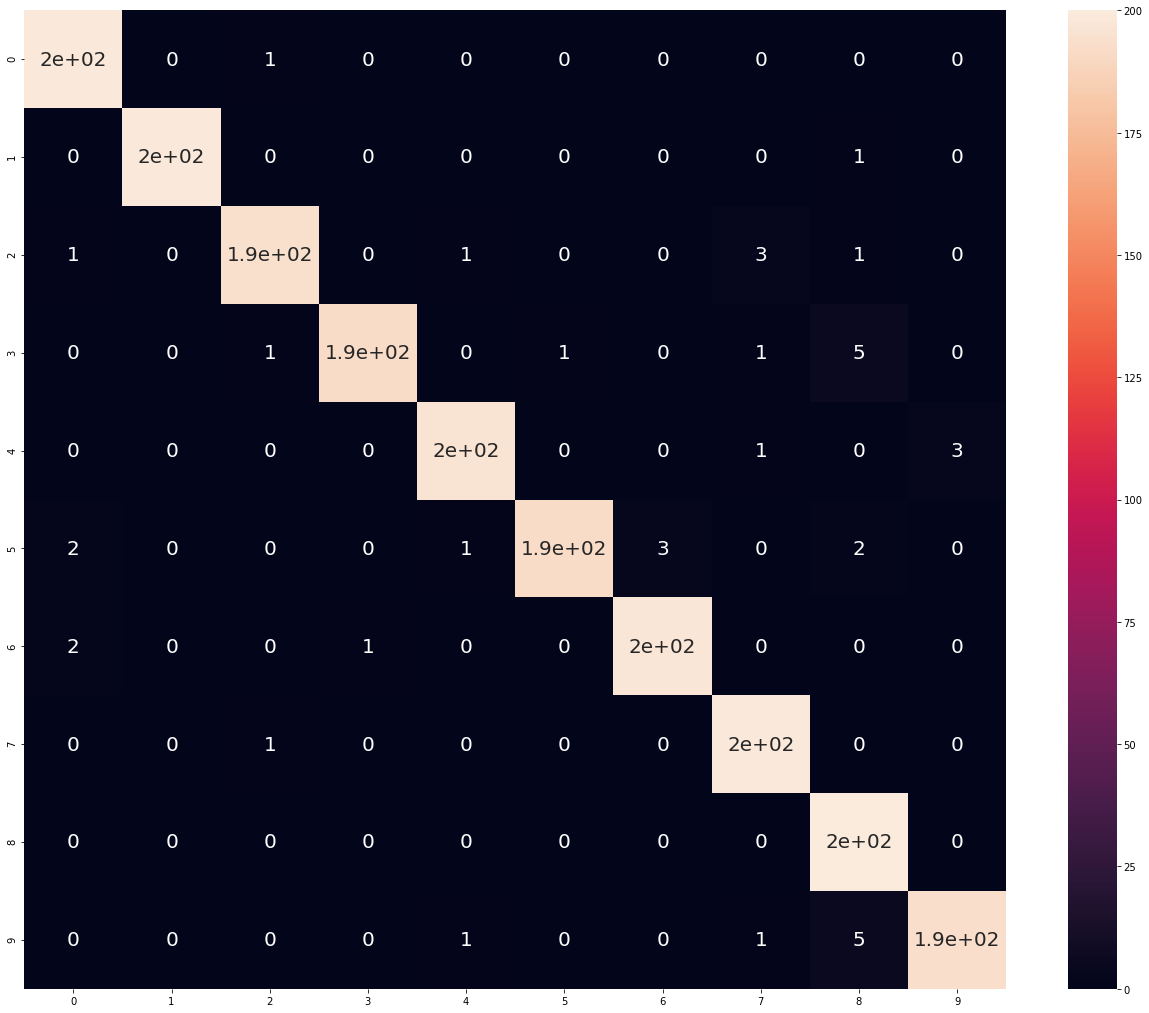

In [53]:
label_name=["0","1","2","3","4","5","6","7","8","9"]
conf_mat(y_tst, y_predicted ,  label_name)

## 4.2 Table Results

|  ............    | ............ | ............ | ............   |............ | ............ | ............|............
|-|-|-|-|-|-|-|-
| .  |  . <td colspan=2>PCA   <td colspan=2>DCT <td colspan=2>HOG
    
|Classifier|Features|Accuracy|time|Accuracy|time|Accuracy|time
|-|-|-|-|-|-|-|-
| | | |+13.4| |+1.9| |+25.1
|kmeans Clustering| 1| 0.67|5.39|0.6655|10.567|0.7040|16.6874
|kmeans Clustering| 4| 0.87|4.54|0.836|7.323|0.894|11.508
|kmeans Clustering| 16| 0.94|8.034|0.924|9.847|0.934|19.378
|GMM| 1| 0.66|112.96|0.542|56.96|0.5205|231.26
|GMM| 4| 0.3515|114.95|0.739|182.71|0.8475|185.64
|GMM| 16| 0.9275|133.89|0.181|582.49|0.745|917.78
|SVM| Linear| 0.9365|1.14|0.9255|83.79|0.967|0.69
|SVM| RBF | 0.9775|1.957|0.9625|1.125|0.9745|1.08

|Classifier|Features|Accuracy|time|
|-|-|-|-
|CNN| 6-relu| 0.981|24.2
|CNN| 8-sigmoid| 0.976|25.6

## 4.3 comment

> GMM is Too slow and the results are not good.

> GMM 16  is overfetting the DCT features.

> SVM is fast and accurate.

> linear SVM training time with DCT takes alot of time.

> RBF SVM shows the best results , combined with PCA features.

## 4.4 CNN comment

> CNN classifier needed A powerful GPU (NVIDIA RTX 3060ti) to run comparatively in time to other Classifiers that run on CPU
>> * this maybe considered as an advantage as it accelerates with parallelism while other classifiers don't
>> * And it  maybe considered as a disadvantage for computational complexity and power consumption.


> CNN classifier has the advantage of not needing a separate feature extraction as it may consume time to extract those features especially PCA and HOG.
>> However DCT is too fast and provide good accuracy for little time.

> CNN has the advantage of accuracy increasing with time by iterating the data set more, which is great considering it already has the best accuracy with the single dataset iteration (batch normalized).

> Increasing the complexity by sigmoid and extra filters to the original LeNet is useless and didn't add adventage to time or accuracy. 